In [61]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split

In [62]:
mean_height = 80
mean_width = 384

def build_data(path = './table_data'):
    all_files = os.listdir(path + '/with_border')

    files_noisy = []
    files_clean = []

    hoehen = []
    breiten = []

    for _, file in enumerate(all_files):
        img_noisy = cv2.imread(path + '/with_border/' + file, cv2.IMREAD_GRAYSCALE)
        if img_noisy is None:
            continue

        h, w = img_noisy.shape
        hoehen.append(h)
        breiten.append(w)

    #mean_height = int(np.mean(hoehen))
    #mean_width = int(np.mean(breiten))

    #if mean_height % 2 != 0:
    #    mean_height = mean_height + 1
#
    #if mean_width % 2 != 0:
    #    mean_width = mean_width + 1

    for _, file in enumerate(all_files):
        img_noisy = cv2.imread(path + '/with_border/' + file, cv2.IMREAD_GRAYSCALE)
        img_clean = cv2.imread(os.path.join(path + '/without_border/', file).replace('.png', '_onlyBlue.png'), cv2.IMREAD_GRAYSCALE)

        if img_noisy is None or img_clean is None:
            continue

        img_noisy = cv2.resize(img_noisy, (mean_width, mean_height))
        img_clean = cv2.resize(img_clean, (mean_width, mean_height))

        img_noisy = cv2.bitwise_not(img_noisy)
        img_clean = cv2.bitwise_not(img_clean)

        files_noisy.append(img_noisy)
        files_clean.append(img_clean)

    if len(files_noisy) != len(files_clean):
        print('Test und Train Daten stimmen nicht überein!', len(files_noisy), len(files_clean))
        
        return None, None

    return np.stack(files_noisy, axis=0), np.stack(files_clean, axis=0)

In [63]:
X_data, y_data = build_data()

if X_data is not None:
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)

    train_shape = X_train.shape
    test_shape = X_test.shape

    X_train = [image/255 for image in X_train]
    X_test = [image/255 for image in X_test]
    y_train = [image/255 for image in y_train]
    y_test = [image/255 for image in y_test]

    X_train = np.reshape(X_train, (train_shape[0], train_shape[1], train_shape[2], 1))
    y_train = np.reshape(y_train, (train_shape[0], train_shape[1], train_shape[2], 1))

    X_test = np.reshape(X_test, (test_shape[0], test_shape[1], test_shape[2], 1))
    y_test = np.reshape(y_test, (test_shape[0], test_shape[1], test_shape[2], 1))

In [64]:
print(X_train.shape)
print(y_train.shape)
print(mean_height) 
print(mean_width)

(641, 80, 384, 1)
(641, 80, 384, 1)
80
384


In [65]:
input_data = tensorflow.keras.layers.Input(shape=(mean_height, mean_width, 1))

#Encoder part
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(256, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)



#Decoder Part
decoder = tensorflow.keras.layers.Conv2DTranspose(256, (3,3), padding="same", activation='relu', name="DecodeConv1")(encoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoded = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

autoencoder = tensorflow.keras.models.Model(inputs=input_data, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 80, 384, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 76, 380, 64)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 38, 190, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 36, 188, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 18, 94, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 92, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 8, 46, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DecodeConv1 (Conv2DTranspose)   │ (None, 8, 46, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_41 (UpSampling2D) │ (None, 16, 92, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_56             │ (None, 18, 94, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_42 (UpSampling2D) │ (None, 36, 188, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_57             │ (None, 38, 190, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_43 (UpSampling2D) │ (None, 76, 380, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ (None, 80, 384, 1)     │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,201 (5.08 MB)

 Trainable params: 1,331,201 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
autoencoder.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 0.0048 - val_loss: 0.0040
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0038 - val_loss: 0.0034
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0037 - val_loss: 0.0033
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0036 - val_loss: 0.0032
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0034 - val_loss: 0.0028
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0030 - val_loss: 0.0027
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0030 - val_lo

In [75]:
def build_validate_data(path = './table_data'):
    all_files = os.listdir(path + '/validate_folder')

    files = []
    for _, file in enumerate(all_files):
        img = cv2.imread(path + '/validate_folder/' + file, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

    for _, file in enumerate(all_files):
        img = cv2.imread(path + '/validate_folder/' + file, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        img = cv2.resize(img, (mean_width, mean_height))

        img = cv2.bitwise_not(img)
    
        files.append(img)

    return np.stack(files, axis=0)

Noisy test images


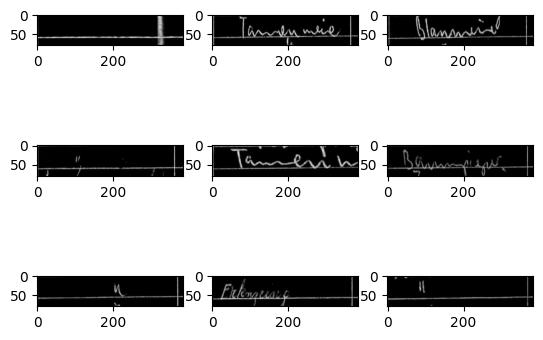

Reconstructed images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


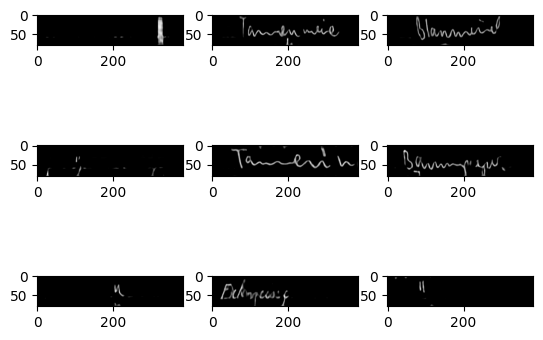

In [76]:
X_validate = build_validate_data()

offset = 50

print("Noisy test images")
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_validate[i+offset,:,:], cmap='gray')
plt.show()

#print("clean test images")
#for i in range(9):
#    plt.subplot(330 + 1 + i)
#    plt.imshow(y_test[i+offset,:,:], cmap='gray')
#plt.show()

print("Reconstructed images")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([X_validate[i+offset]]))
    op_image = np.reshape(output[0]*255, (mean_height, mean_width))
    plt.imshow(op_image, cmap='gray')
plt.show()